# MovieLens 32M 数据探索性分析 (EDA)
本笔记本旨在通过可视化和统计分析，深入了解 MovieLens 数据集的特征，为后续召回和排序算法的设计提供依据。

## 准备工作：导入库与加载数据
在这个单元格中，我们将加载预处理好的 Parquet 文件，并配置绘图环境以支持中文显示。

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import warnings

# 忽略烦人的警告
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# 设置绘图风格
plt.style.use('ggplot')
%matplotlib inline

# 彻底解决中文字体乱码问题 (针对 macOS)
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'PingFang SC', 'Heiti TC', 'sans-serif'] 
plt.rcParams['axes.unicode_minus'] = False

# 加载处理后的数据
data_dir = Path('../data/processed')
ratings = pd.read_parquet(data_dir / 'ratings.parquet')
movies = pd.read_parquet(data_dir / 'movies.parquet')

print(f'成功加载 {len(ratings):,} 条评分数据 and {len(movies):,} 条电影元数据。')

成功加载 32,000,204 条评分数据 and 87,585 条电影元数据。


## 1. 稀疏度分析 (Sparsity Analysis)

In [2]:
n_users = ratings['userId'].nunique()
n_movies = ratings['movieId'].nunique()
actual_ratings = len(ratings)
possible_ratings = n_users * n_movies
sparsity = (1 - actual_ratings / possible_ratings) * 100

print(f'用户总数: {n_users:,}')
print(f'电影总数: {n_movies:,}')
print(f'理论最大评分组合: {possible_ratings:,}')
print(f'实际评分数量: {actual_ratings:,}')
print(f'数据集稀疏度: {sparsity:.4f}%')

用户总数: 200,948
电影总数: 84,432
理论最大评分组合: 16,966,441,536
实际评分数量: 32,000,204
数据集稀疏度: 99.8114%


## 2. 物品长尾效应分析 (Long-tail Effect)

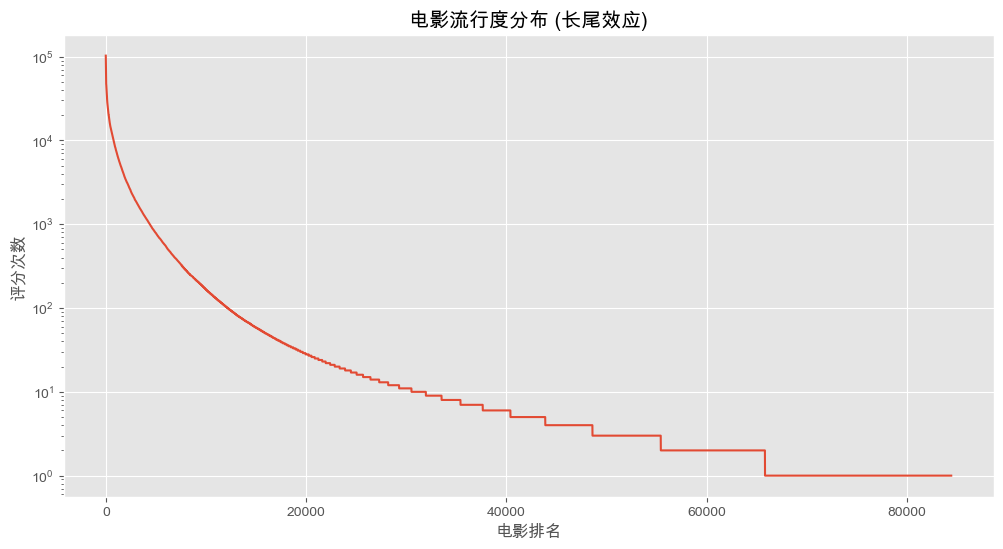

前 10% 的热门电影占据了全站 95.70% 的评分。


In [3]:
movie_counts = ratings.groupby('movieId').size().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
plt.plot(movie_counts.values)
plt.title('电影流行度分布 (长尾效应)')
plt.xlabel('电影排名')
plt.ylabel('评分次数')
plt.yscale('log')
plt.show()

top_10_percent_cutoff = int(len(movie_counts) * 0.1)
top_10_percent_ratings = movie_counts.iloc[:top_10_percent_cutoff].sum()
percentage = (top_10_percent_ratings / len(ratings)) * 100
print(f'前 10% 的热门电影占据了全站 {percentage:.2f}% 的评分。')

## 3. 用户活跃度分析

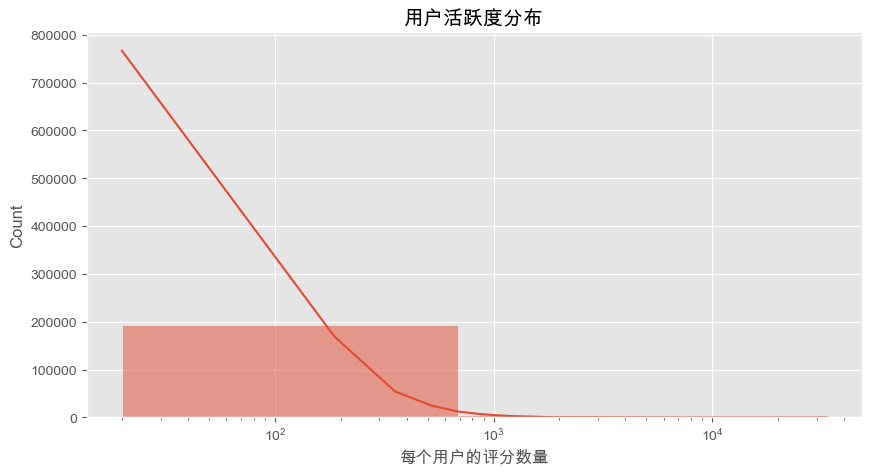

用户平均评分数: 159.2
最少评分数: 20
最大评分数: 33332


In [4]:
user_counts = ratings.groupby('userId').size().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.histplot(user_counts, bins=50, kde=True)
plt.title('用户活跃度分布')
plt.xlabel('每个用户的评分数量')
plt.xscale('log')
plt.show()

print(f'用户平均评分数: {user_counts.mean():.1f}')
print(f'最少评分数: {user_counts.min()}')
print(f'最大评分数: {user_counts.max()}')

## 4. 电影题材分布分析

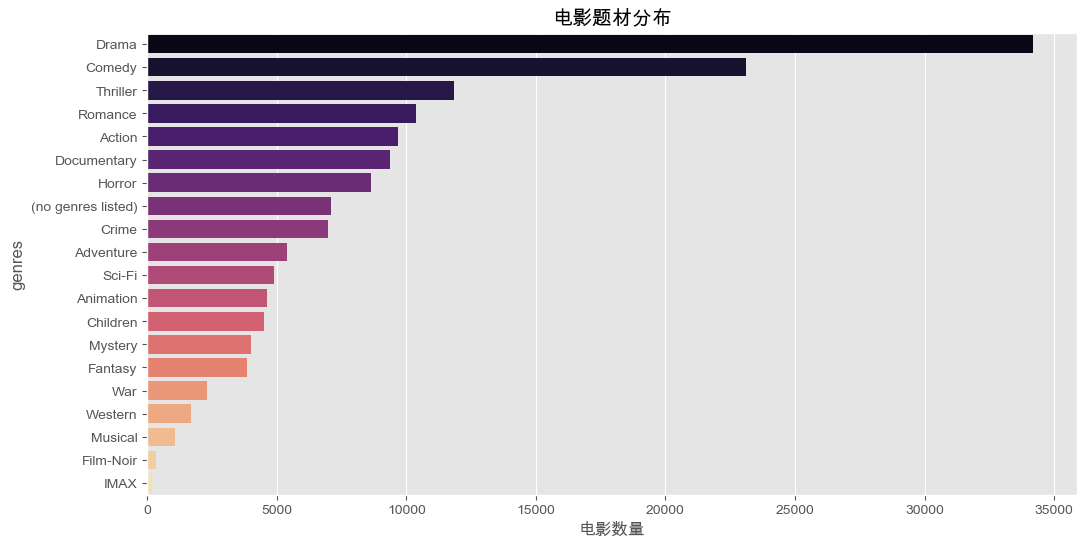

In [5]:
genres_exploded = movies.explode('genres')
genre_counts = genres_exploded['genres'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, hue=genre_counts.index, palette='magma', legend=False)
plt.title('电影题材分布')
plt.xlabel('电影数量')
plt.show()

## 5. 评分值分布分析

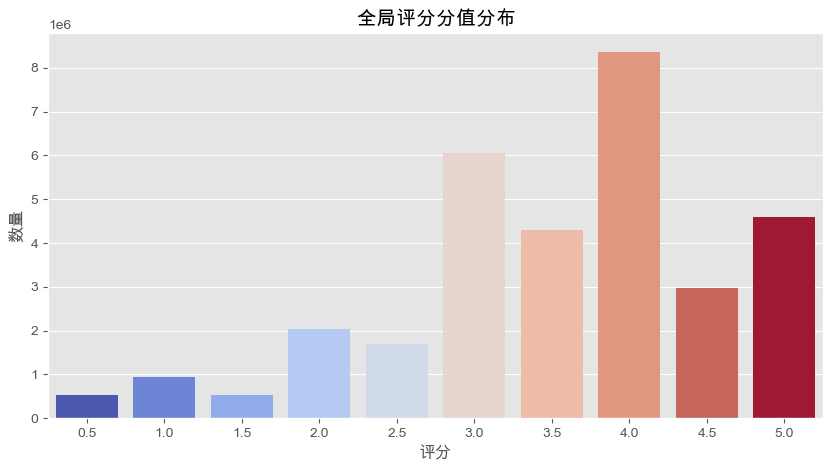

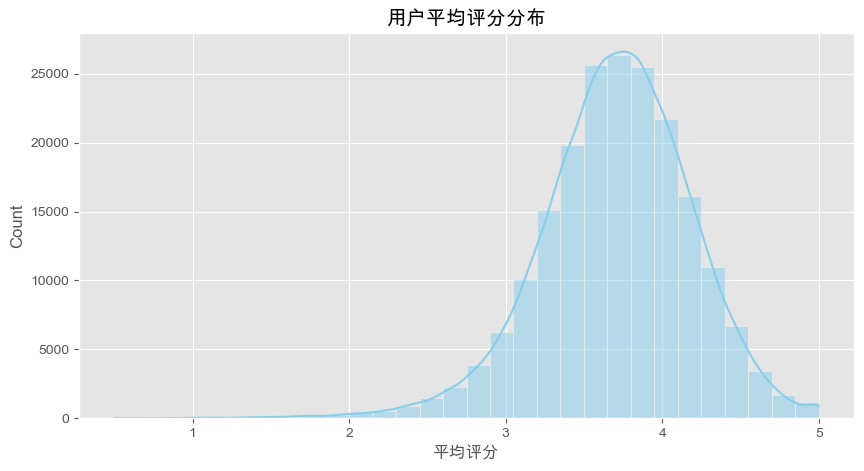

In [6]:
plt.figure(figsize=(10, 5))
sns.countplot(x='rating', hue='rating', data=ratings, palette='coolwarm', legend=False)
plt.title('全局评分分值分布')
plt.xlabel('评分')
plt.ylabel('数量')
plt.show()

user_avg_ratings = ratings.groupby('userId')['rating'].mean()
plt.figure(figsize=(10, 5))
sns.histplot(user_avg_ratings, bins=30, kde=True, color='skyblue')
plt.title('用户平均评分分布')
plt.xlabel('平均评分')
plt.show()